In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from scipy.stats import norm 

In [5]:
from datetime import datetime, time
import pandas_datareader.data as pdr
import yfinance as yf

/Users/shalini/workspace/Black-Scholes/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [63]:
def black_scholes(s0, k, r, t, sigma, y, stock, expiry, option_type):
    T = t/252  #daily to yearly 
    s = s0 * np.exp(-y*T)
    d1 = (np.log(s0/k) + ((r-y + sigma**2/2)*T))/ (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))
    n_d1 = norm.cdf(-d1)
    n_d2 = norm.cdf(-d2)
    

    opt = stock.option_chain(expiry)
    #vol=0.001*np.arange(1,1001)
   
   #calculating option price and implied volatility
    if option_type == 'Call':
        value = s * norm.cdf(d1) - k * np.exp(-r*T) * norm.cdf(d2) 
        opt_value = opt.calls
        price = opt_value.loc[opt_value.strike == k, 'lastPrice'].values[0]
        #print(price)
        im_vol = abs(value - price)*0.1
           

    else:
        value =  k * np.exp(-r *t)* n_d2 - s * n_d1
        opt_value = opt.puts
        price = opt_value.loc[opt_value.strike == k, 'lastPrice'].values[0]
        im_vol = abs(value - price)*0.1
        
        
    
    # calculating break even point
    if option_type == 'Call': 
        bep = k + value
    else:
        bep = k - value
        
    #delta
    if y >0.0 and T > 0.0:
        yfac = np.exp(-y*T)
    else:
        yfac = 1.0
    
    if option_type == 'Call' : delta = yfac * norm.cdf(d1) 
    else:  delta = yfac* (norm.cdf(d1) -1)
    
    #gamma
    gamma = (yfac * norm.pdf(d1)) /(s0 * sigma * np.sqrt(T))
    
    #theta
    if option_type =='Call':
        theta = -((s * norm.pdf(d1)*sigma)/(2*np.sqrt(T)) + r * k *np.exp(-r*T)*norm.cdf(d2) - y*s*norm.cdf(d1))
    else:
        theta = -((s * norm.pdf(d1)*sigma)/(2*np.sqrt(T)) - r * k* np.exp(-r*T)*n_d2 +  y*s*norm.cdf(-d1))
    
    #vega
    vega = (s* np.sqrt(T) * norm.pdf(d1))/100
    
    #rho
    if option_type == 'Call':
        rho = k * T * np.exp(-r*T)*norm.cdf(d2)
    else:
        rho = -(k * T * np.exp(-r*T)*n_d2)

    #implied volatility

    option_values = {
        "option_type" : option_type,
        "premium" : value.round(4), "Breakeven point": bep.round(4),  "detla" :  delta.round(4), "gamma" : gamma.round(4), 
        "theta" : theta.round(4), "vega" : vega.round(4),'rho' :  rho.round(4) , "implied volatility  " :im_vol.round(4)
    }
    
    return option_values

##### Ticker and expiry date

In [7]:
ticker = 'QCOM'
expiry_date = '12-15-2023'


In [8]:
today = datetime.now().date()
one_year_ago = today.replace(year = today.year-1)

In [9]:
stock = yf.Ticker(ticker)
df = yf.download(ticker,start = one_year_ago, end = today,rounding = True )


[*********************100%%**********************]  1 of 1 completed


In [10]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-28,122.16,123.45,118.85,119.54,116.42,7087500
2022-11-29,120.14,121.37,118.32,118.38,115.29,6277600
2022-11-30,118.75,126.60,118.07,126.49,123.98,12776700
2022-12-01,126.72,128.20,125.68,126.81,124.29,7924800
2022-12-02,123.71,125.82,123.12,125.66,123.16,6122200


In [11]:
df_1 = df['Adj Close']
df_returns = df_1.to_frame()

In [12]:
#calculating returns
df_returns['returns'] = df['Adj Close'].pct_change()

In [13]:
df_returns['cum_ret'] = (df_returns['returns'] +1).cumprod()


In [14]:
df_returns.dropna().head()

,Adj Close,returns,cum_ret
Date,,,
2022-11-29,115.29,-0.009706,0.990294
2022-11-30,123.98,0.075375,1.064937
2022-12-01,124.29,0.002500,1.067600
2022-12-02,123.16,-0.009092,1.057894
2022-12-05,120.85,-0.018756,1.038052


In [15]:
log_returns = np.log(df['Close']/df['Close'].shift(1)).dropna()


In [16]:
df_returns['log_returns'] = log_returns
df_returns.tail()

,Adj Close,returns,cum_ret,log_returns
Date,,,,
2023-11-20,129.51,0.000309,1.112438,0.000309
2023-11-21,127.02,-0.019226,1.091050,-0.019414
2023-11-22,127.50,0.003779,1.095173,0.003772
2023-11-24,127.75,0.001961,1.097320,0.001959
2023-11-27,128.20,0.003523,1.101185,0.003516


#### Plotting returns

<Axes: xlabel='Date', ylabel='Adj Close'>

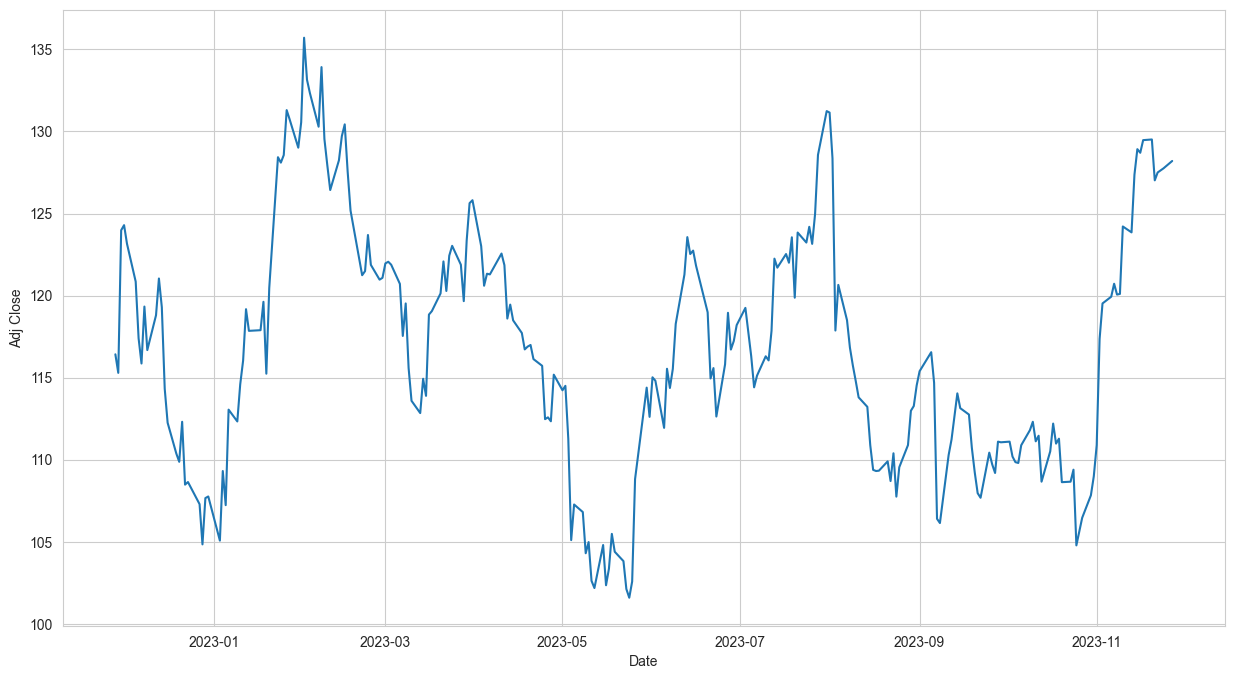

In [17]:
#Visualize the price
sns.set_style('whitegrid')
plt.figure(figsize=(15,8))
sns.lineplot(data = df_returns['Adj Close'] )

<Axes: xlabel='Date', ylabel='returns'>

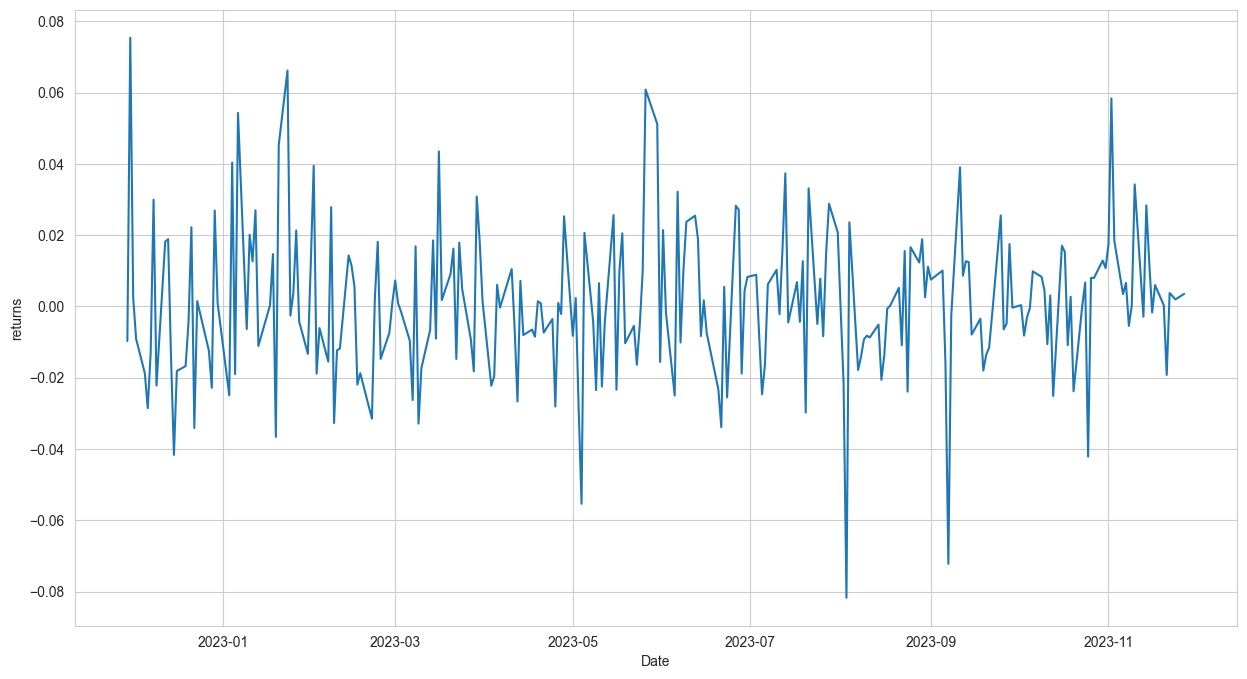

In [18]:
#Visualizing log return
plt.figure(figsize=(15,8))
sns.lineplot(data = df_returns['returns'])

<Axes: xlabel='returns', ylabel='Count'>

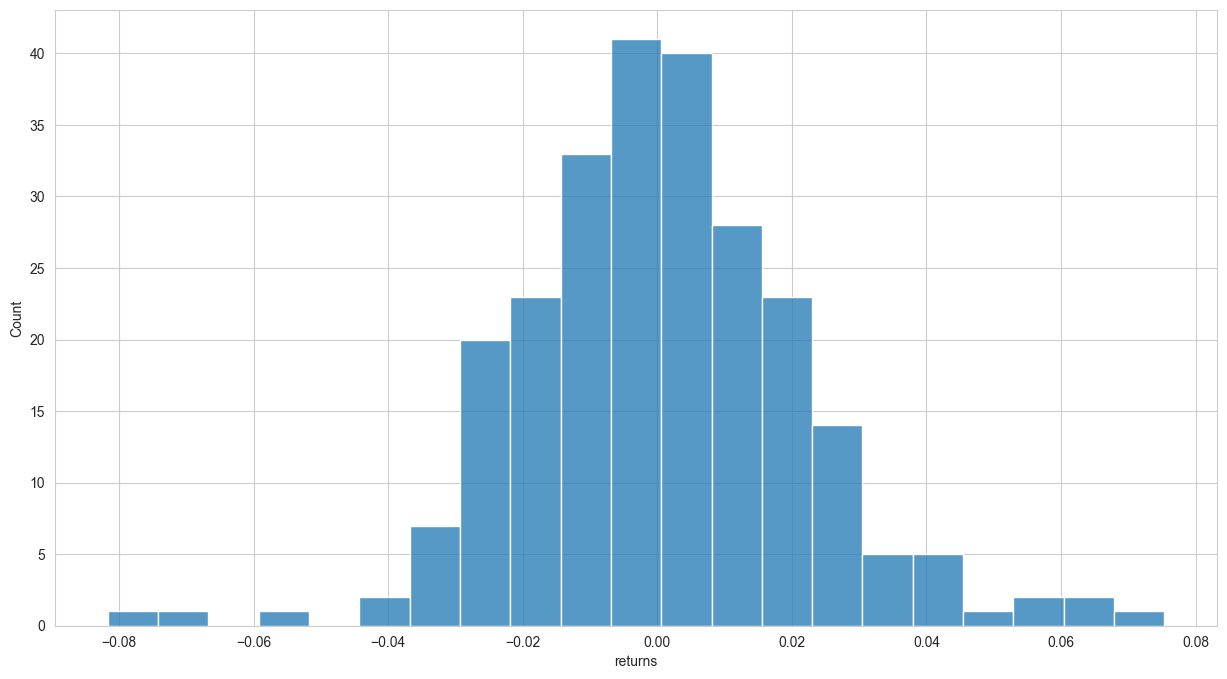

In [19]:
#Visualizing return
plt.figure(figsize=(15,8))
sns.histplot(data = df_returns['returns'])

Annualised dividend

In [20]:
dividends = stock.history(start= one_year_ago, end = today)['Dividends']
#type(dividends)
annual_div = dividends.sum()

##### Sigma 

In [21]:
sigma = np.sqrt(252)*(df_returns['log_returns'].std())
sigma

0.3314362314872905

In [22]:
sigma_ret = np.sqrt(252)*(df_returns['returns'].std())
sigma_ret

0.33277266693291496

#### Risk-free rate

In [23]:
#risk-free rate, as the 6 month U.S. treasury yield which could get from ^TNX
r = 0.0539

#### Current stock price

In [24]:
#current stock price
s = df_returns['Adj Close'].iloc[-1]
s

128.2

Dividend yield

In [25]:
y = annual_div / s
y

0.024180967238689552

#### Time

In [26]:
# time remaining untill expiration in days
t = (datetime.strptime(expiry_date, "%m-%d-%Y") - datetime.utcnow()).days 
t

16

#### Strike price

In [27]:
strike_price = 130
#sigma = 0.21842

Option price from yahoo finance

In [28]:
#expiry date for option price
expiry_date_new = "2023-12-15"


#### Calculating option value

In [62]:
black_scholes(s, strike_price, r, t, sigma,y,stock, expiry_date_new, 'Call')

{'option_type': 'Call',
 'premium': 3.5577,
 'Breakeven point': 133.5577,
 'detla': 0.4584,
 'gamma': 0.037,
 'theta': -34.9633,
 'vega': 0.128,
 'rho': 3.5056,
 'implied volatility  ': 0.1948}

#### Calculating probability of profit

POP = N[d2(S1)] - N[d2(S2)] 
where S1 < S2; N - cumulative distribution function assuming normal distribution

In [39]:
def d2_norm_cdf(s,k,sigma, r, t):
    T = t/252
    d2 = -(np.log(k/s) - (r - (sigma**2))*T) / (sigma * np.sqrt(T))
    return norm.cdf(d2)
    

In [40]:
s1 = 133.36
s2 = 136.85

In [41]:
#calculating probabiltiy of profit
pop = (d2_norm_cdf(s2,strike_price,sigma,r,t) - d2_norm_cdf(s1,strike_price,sigma,r,t))*100
print(" Probability of Profit is .{0:8.4f}%".format(pop) )

 Probability of Profit is . 11.2725%


In [47]:
from optionlab import black_scholes 

In [48]:
black_scholes.getBSinfo(s,strike_price, r, sigma, t/252, y)

(3.56,
 5.11,
 0.45843519073321876,
 -0.5400306877289289,
 -34.9632693766634,
 -31.075452126165672,
 0.03700919467599902,
 0.1279985675503523,
 0.4255231958776964,
 0.5729426825844512)

In [49]:
black_scholes.getimpliedvol('call',1.61,s,strike_price,r,t/252)

0.171